# **Project Leyenda - Deliverable 2**

*Group* : 
|Author|Center|Promo|Mail| 
|---|---|---|---|
|De Jesus Correia Alexandre|Nanterre|FISE INFO A5|alexandre.dejesuscorreia@viacesi.fr|
|Charlut Steven|Nanterre|FISE INFO A5|steven.charlut@viacesi.fr|
|Debraize Killian|Nanterre|FISE INFO A5|killian.debraize@viacesi.fr|
|Raies Youssef|Nanterre|FISE INFO A5|youssef.raies@viacesi.fr|
|Kinya Mwongera Sharon|Nanterre|FISE INFO A5|sharon.kinyamwongera@viaceis.fr|

![denoizing](https://i.imgflip.com/96cuk7.jpg)

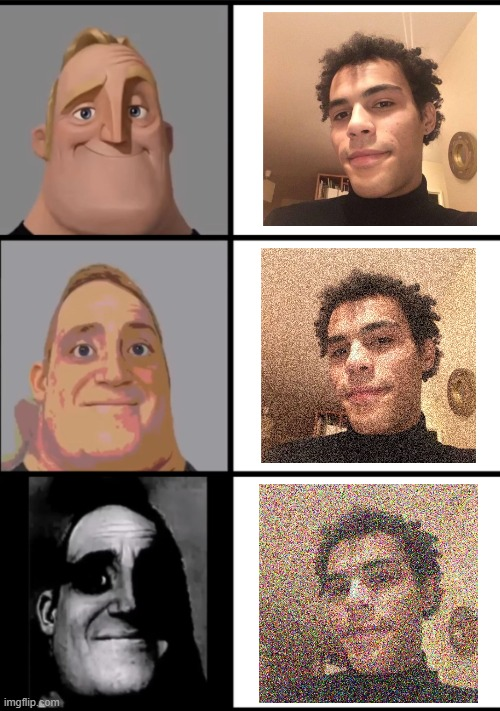


In [150]:
%matplotlib inline

In [151]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Flatten, Dense, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# 1. File Loading Section
## Load the dataset 


In [152]:
# Load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (128, 128))  # Resize for consistency
            images.append(img)
    return np.array(images)

In [153]:
# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            # Resize the image to the target size
            img_resized = cv2.resize(img, target_size)
            images.append(img_resized)
    return np.array(images)

# Define the folder path
absolute_path = r"../../DataSets/data_set_livrable_2"

# Load dataset and resize images
dataset_images = load_images_from_folder(absolute_path, target_size=(128, 128))

# Normalize the data
dataset_images = dataset_images.astype('float32') / 255.0

# Now your images are loaded, resized, and normalized
print(f"Loaded {len(dataset_images)} images from the dataset.")

Loaded 148 images from the dataset.


In [154]:
# Split into training and test sets
train_images = dataset_images[:int(len(dataset_images) * 0.8)]
test_images = dataset_images[int(len(dataset_images) * 0.8):]

In [155]:

# Add noise to the images
noise_factor = 0.5
train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_noisy = np.clip(train_noisy, 0., 1.)
test_noisy = np.clip(test_noisy, 0., 1.)

In [156]:
# Define the convolutional autoencoder
input_img = Input(shape=(128, 128, 3))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Latent space
latent_space = Dense(16, activation='relu')(encoded)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(latent_space)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [157]:
# Summary of the model
autoencoder.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_257 (Conv2D)             │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_258 (Conv2D)             │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32, 32, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_259 (Conv2D)             │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_87 (UpSampling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_260 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_88 (UpSampling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_261 (Conv2D)             │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,651 (178.32 KB)

 Trainable params: 45,651 (178.32 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
# Train the autoencoder
history = autoencoder.fit(train_noisy, train_images,
                          epochs=25,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(test_noisy, test_images))

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 446ms/step - loss: 0.6905 - val_loss: 0.6736
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - loss: 0.6675 - val_loss: 0.6197
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - loss: 0.6205 - val_loss: 0.5777
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - loss: 0.5968 - val_loss: 0.5737
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - loss: 0.5854 - val_loss: 0.5705
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step - loss: 0.5924 - val_loss: 0.5704
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - loss: 0.5885 - val_loss: 0.5622
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - loss: 0.5815 - val_loss: 0.5597
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - loss: 0.5792 - val_loss: 0.5579
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step - loss: 0.5782 - val_loss: 0.5558
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - loss: 0.5703 - val_loss: 0.5537
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - loss: 0.5724 - val_lo

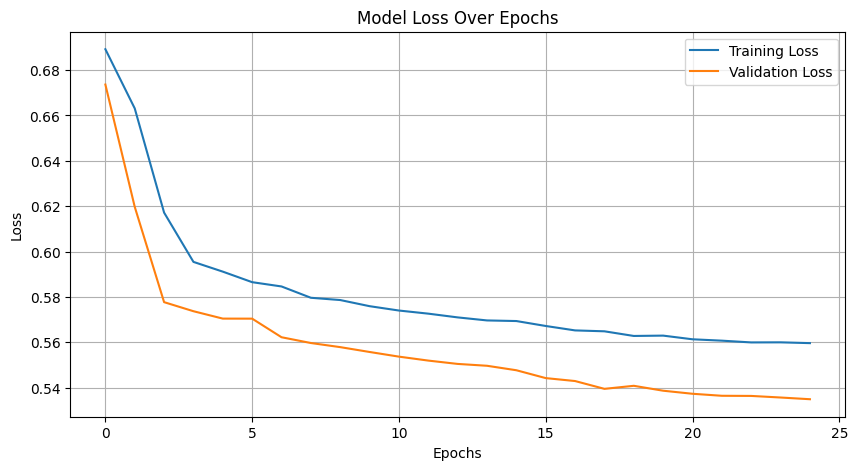

In [159]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 0.6942 - val_loss: 0.6923
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - loss: 0.6895 - val_loss: 0.6930
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 0.6947 - val_loss: 0.6810
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 0.6804 - val_loss: 0.6635
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 0.6527 - val_loss: 0.5985
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - loss: 0.6196 - val_loss: 0.6001
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - loss: 0.6097 - val_loss: 0.5900
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 0.6081 - val_loss: 0.5792
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 0.5981 - val_loss: 0.5726
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - loss: 0.5956 - val_loss: 0.5701
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 0.5888 - val_loss: 0.5659
Epoch 12/25
4/4 ━━

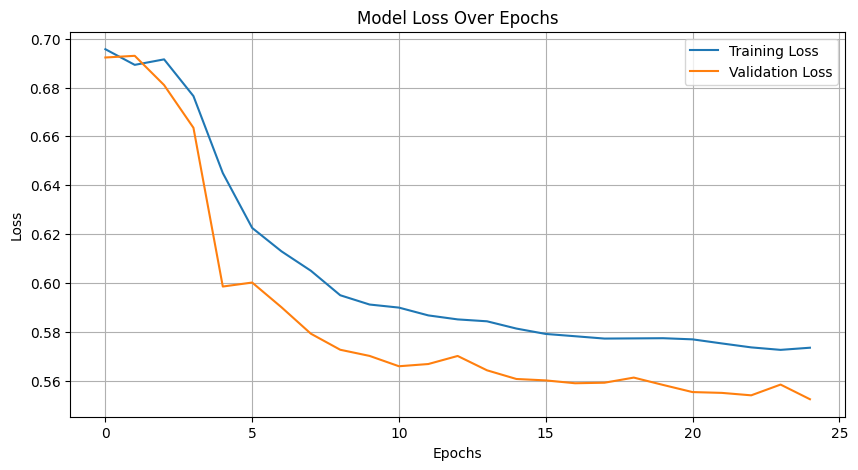

In [168]:
from keras.layers import Conv2DTranspose, concatenate

# Split into training and test sets
train_blurred = autoencoder.predict(train_noisy)
test_blurred = autoencoder.predict(test_noisy)

# Define the convolutional autoencoder
input_img = Input(shape=(128, 128, 3))

# Encoder
x = Conv2D(256, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x) 

# Decoder
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)

decoder = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

# Compile the autoencoder
autoencoder2 = Model(input_img, decoder)
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')

# Summary of the model
#autoencoder2.summary()

# Train the autoencoder
history = autoencoder2.fit(train_blurred, train_images,   
                          epochs=25,                    
                          batch_size=32,                    
                          shuffle=True,         
                          validation_data=(test_blurred, test_images))

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


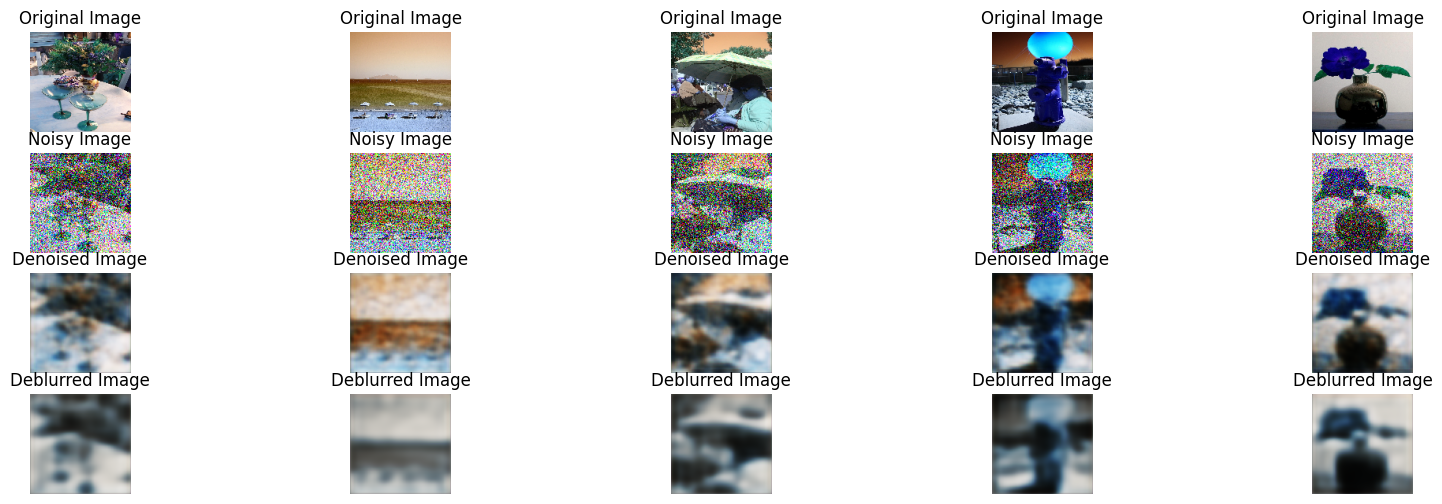

In [169]:
# Evaluate the autoencoder by comparing noisy images with denoised images
decoded_imgs = autoencoder.predict(test_noisy)
decoded_imgs2 = autoencoder2.predict(decoded_imgs)

# Visualize the results
n = 5  # Number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    
    # Display original images
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(test_images[i])
    plt.title("Original Image")
    plt.axis("off")
    
    # Display original noisy images
    ax = plt.subplot(4, n, i + n + 1)
    plt.imshow(test_noisy[i])
    plt.title("Noisy Image")
    plt.axis("off")

    # Display denoised images
    ax = plt.subplot(4, n, i + 2*n + 1)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised Image")
    plt.axis("off")
    
    # Display deblurred images
    ax = plt.subplot(4, n, i + 3*n + 1)
    plt.imshow(decoded_imgs2[i])
    plt.title("Deblurred Image")
    plt.axis("off")

plt.show()